## Modelling Notebook

This notebook is to be used for testing out the various models that you want to use. No preprocessing will be done in this notebook. Steps:

1. Read in `data/final_data.csv` that you created in the `Data Cleaning.ipynb`
2. Try various models and print appropriate metrics (accuracy/MSE etc)
3. Pick a final model and save it as `models/model.pkl`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train=pd.read_csv("../input/train_data.csv",index_col=0)
validation=pd.read_csv("../input/validation_data.csv",index_col=0)
final_test=pd.read_csv("../input/test_data.csv",index_col=0)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV

In [4]:
columns=["Clearsky DHI","Clearsky DNI","Clearsky GHI"]
target=["Clearsky DHI","Clearsky DNI","Clearsky GHI"]

In [5]:
def evaluate(y_true,predictions):
    # Performance Metrics
    print("MSE: ", mean_squared_error(y_true,predictions))
    print("MAE: ", mean_absolute_error(y_true,predictions))
    print("R2: ", r2_score(y_true,predictions))


def train_and_evaluate(model):
    """
    model: Sklearn model instance
    """
    #Training
    X_train=train.drop(columns=columns)
    y_train=train[target]
    print(X_train.shape)
    model.fit(X_train,y_train)

    # Validation
    X_val=validation.drop(columns=columns)
    y_val=validation[["Clearsky DHI","Clearsky DNI","Clearsky GHI"]]
    predictions=model.predict(X_val)

    evaluate(y_val,predictions)

def make_submission(model,name):
    target=["Clearsky DHI","Clearsky DNI","Clearsky GHI"]
    X_test=final_test.drop(columns=columns)
    submission=model.predict(X_test)
    submission_df=pd.DataFrame(submission,columns=target)
    submission_df.to_csv(f"../output/{name}_submission.csv",index=False)
    return submission_df

As we observed earlier, the target has a high number of 0 values. Therefore, it would be a good idea to give every prediction as 0 and check out the error.

In [6]:
zeros=np.zeros_like(validation[["Clearsky DHI","Clearsky DNI","Clearsky GHI"]])
evaluate(validation[["Clearsky DHI","Clearsky DNI","Clearsky GHI"]],zeros)

MSE:  142230.846712608
MAE:  212.12523579165145
R2:  -0.7010882923702167


So despite the overwhelming number of 0s, predicting every number as zero does not seem to give apt results.

In [7]:
lr=LinearRegression()
train_and_evaluate(lr)

(131472, 2)
MSE:  16216.617746964781
MAE:  94.55370071203265
R2:  0.7902240553511589


In [8]:
df=make_submission(lr,"Linear_Regression")

In [9]:
df

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,32.249367,160.519083,124.147512
1,23.592278,108.751498,78.848160
2,14.808085,56.223867,32.883727
3,5.939158,3.189539,-13.524092
4,-2.775102,-54.556086,-61.608000
...,...,...,...
17515,65.808666,513.373336,366.856830
17516,58.507336,469.712910,328.651666
17517,51.050658,425.123539,289.633627
17518,42.534793,374.200450,245.073253


In [10]:
rf=RandomForestRegressor()
train_and_evaluate(rf)

(131472, 2)
MSE:  1076.0131805144026
MAE:  14.766629267400281
R2:  0.9552603958400727


Random Forests seem to be performing quite well even without any tuning. Perhaps tree based models would work better on the dataset.

In [11]:
make_submission(rf,"Random_Forest")

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,0.00,0.00,0.00
3,0.00,0.00,0.00
4,0.00,0.00,0.00
...,...,...,...
17515,55.97,583.50,178.75
17516,40.26,379.12,86.15
17517,13.15,184.39,18.43
17518,0.00,0.00,0.00


<BarContainer object of 2 artists>

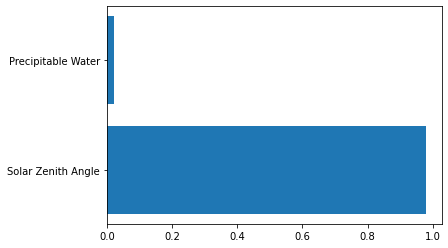

In [12]:
plt.barh(train.drop(columns=columns).columns, rf.feature_importances_)

In [13]:
# params={
#     "n_estimators":[150,200,300,500],
#     "max_depth":[3,4,5]
# }
# grid=GridSearchCV(rf,params,scoring="neg_mean_squared_error",verbose=2)

In [14]:
# train_and_evaluate(grid)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
model=Sequential()
model.add(layers.Dense(100,input_shape=(train.shape[1]-3,),activation="relu"))
model.add(layers.Dense(50,activation="relu"))
model.add(layers.Dense(25,activation="relu"))
model.add(layers.Dense(3,activation="linear"))

In [17]:
model.compile(optimizer="adam",loss="mse",metrics=["mse","mae"])

In [18]:
X_train=train.drop(columns=columns)
y_train=train[columns]
X_val=validation.drop(columns=columns)
y_val=validation[columns]

In [19]:
performance = model.fit(X_train, y_train, batch_size=64,
                    epochs=50, validation_data=(X_val, y_val),shuffle=False)

Epoch 1/50
2055/2055 [==============================] - 2s 777us/step - loss: 34033.0039 - mse: 34033.0039 - mae: 97.5585 - val_loss: 1962.8739 - val_mse: 1962.8739 - val_mae: 29.3646
Epoch 2/50
2055/2055 [==============================] - 2s 733us/step - loss: 1561.7246 - mse: 1561.7246 - mae: 24.8928 - val_loss: 2767.0901 - val_mse: 2767.0901 - val_mae: 32.9008
Epoch 3/50
2055/2055 [==============================] - 2s 735us/step - loss: 1247.0393 - mse: 1247.0393 - mae: 20.6908 - val_loss: 1308.5973 - val_mse: 1308.5973 - val_mae: 21.4568
Epoch 4/50
2055/2055 [==============================] - 1s 722us/step - loss: 1145.3910 - mse: 1145.3910 - mae: 18.9583 - val_loss: 1131.1921 - val_mse: 1131.1921 - val_mae: 19.0975
Epoch 5/50
2055/2055 [==============================] - 2s 736us/step - loss: 1119.9951 - mse: 1119.9951 - mae: 18.1855 - val_loss: 932.3904 - val_mse: 932.3904 - val_mae: 17.1154
Epoch 6/50
2055/2055 [==============================] - 1s 716us/step - loss: 1092.6693 - 

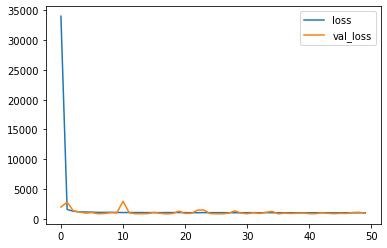

In [20]:
plt.plot(performance.history['loss'])
plt.plot(performance.history['val_loss'])
plt.legend(["loss","val_loss"])

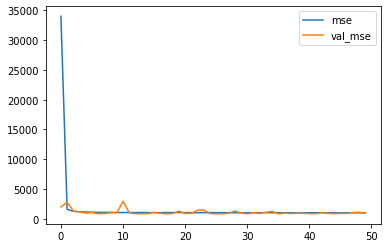

In [21]:
plt.plot(performance.history['mse'])
plt.plot(performance.history['val_mse'])
plt.legend(["mse","val_mse"])